<center> <h1> Agent-Based Model of Panic</h1> </center>

# Imports

In [ ]:
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statistics
import numpy as np
import pyabc
import seaborn as sns
from pyabc.transition.multivariatenormal import  MultivariateNormalTransition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

random.seed(1234)

# Define model class

In [20]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='homogeneous', verbose=False):
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.mode = mode
        self.verbose = verbose

        self.alpha = 0.1
        
        self.gamma = 0.1

        self.beta = 0.5
        
        #creating lists
        self.num_infected_per_iteration = list()
               
        #model time
        self.time = 0
        
        self.infected_agents = list() 
        self.num_of_infected = 0
        
        #create the agents, random.choice allocates agents to a type 
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                self.agents.append(Agent(self))
    
        
        # if the model hasn't finished running yet
        self.model_finished = False 
    
    def get_num_infected(self):
        #gets number of agents that are infected
        return len(([ a for a in self.agents if a.state==1 ]))

    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents: # every agent, in every iteration, moves forward
                agent.step()
            
            if self.verbose:
                for i, agent in enumerate(self.agents):
                    print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
                    if self.mode == 'homogeneous':
                        print('my likelihood:{}, my state:{}'.format(agent.likelihood, agent.state))
            
            self.num_infected_per_iteration.append(self.get_num_infected())
            
            if self.verbose:
                if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                    print('step: {},  total infected:{}'.format(t, self.get_num_infected()))
    
            #step time
            self.time += 1
            
        infected_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                infected_agents.append(agent)
        self.num_of_infected = len(infected_agents)
        self.infected_agents.append(self.num_of_infected)
            
        #once each iteration is done, model is finished
        self.model_finished = True 


    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration],
                    c="red", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
        
        ax.set_title("Number of infected per iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of infected")
        ax.legend(loc='upper left')
        
        plt.savefig("Number of Infected Agents Through Time", bbox_inches="tight")

## Defining agent class

In [21]:
class Agent():
    
    def __init__(self, model, alpha = 0.1, beta = 0.1, gamma= 0.1):
        
        self.state = 0
        
        model.alpha = alpha
        
        model.gamma = gamma

        model.beta = beta 
        
        self.likelihood = 0

        self.likelihood_heterogeneous_one = []
        self.likelihood_heterogeneous_two = []
        
        #pointer to the model class
        self.model = model
        
        #For the simple heterogenous simulation, 
        #agents draw betas from normal distribution
        if model.mode == ['heterogeneous']:
            self.Beta = self.heterogeneous_model_one_beta

        r = random.random()
        

    def beta(self):
        return stats.norm.rvs(loc = 0, scale = 1)
    
    def prob(self):
        return stats.norm.rvs(loc = 0, scale = 1) 

    def step(self):
        if self.state == 0: 
            self.homogeneous_model()
            self.other_agents()
                
        else:
            self.recover()
          
    def homogeneous_model(self):
        
        Agent_i = random.choice(model.agents)
        
        if Agent_i.state == 1:
            self.likelihood = model.alpha + model.beta
        else:
            self.likelihood = model.alpha
        
        r = random.random()
        
        if r < self.likelihood: 
            self.state = 1
         
        assert self.likelihood < 1

    def heterogeneous_model(self):
        num_infected = model.get_num_infected()
        
        self.likelihood_heterogeneous_one = list()
        
        if model.mode == ['heterogeneous']:
            likelihood = self.alpha + (num_infected * self.heterogeneous_model_one_beta)
            
            if r < likelihood: 
                self.state = 1
            else:
                self.other_agents()
                
            self.likelihood_heterogeneous_one.append(self.likelihood)
            

    def other_agents(self):
        if model.num_of_infected > model.num_of_agents/1.5:
            self.state = 1
    
    def recover(self):
        r1 = random.random()
        if self.state == 1:
            if r1 < model.gamma:
                self.state = 0

## Running model

In [ ]:
model = Model(num_of_agents=100, num_iterations=100, mode = 'homogeneous')
model.run()
model.graph_num_infected()

## ABC

### Creating Functions

In [50]:
def my_model(input_params_dict):
    """
    Creating the model function that feeds the ABC package my ABM.
    This function includes the creation of a dictionary, 
    which contains the parameter of interest: 'number of panicked' agents
    """
    beta = input_params_dict["param_b"]
    
    model = Model(num_of_agents=10, num_iterations=50, mode = 'homogeneous')
    model.beta = beta
    model.run()

    result = model.num_infected_per_iteration
    return {"model_result": result}

In [51]:
def distance(model_result_dict, observations_dict):
    """
    The function that calculates the absolute difference
    between my ABM results and the ABC observations.
    """
    model_result = model_result_dict['model_result']
    model_result = np.array(model_result)
    observation = observations_dict['observation'] 
    observation = np.array(observation)
    
    return abs (model_result - observation).any()

In [52]:
"""
This is the true beta i.e. rate of infection 
"""
PARAM_B = 0.1

In [53]:
truth_model = my_model({ "param_b": PARAM_B})
obs = truth_model['model_result']

### Defining Priors

In [54]:
"""
Here, I'm assuming that the 'Number of panicked' parameter is uniformly distributed
"""
param_b_rv = pyabc.RV("uniform", 0, 1)

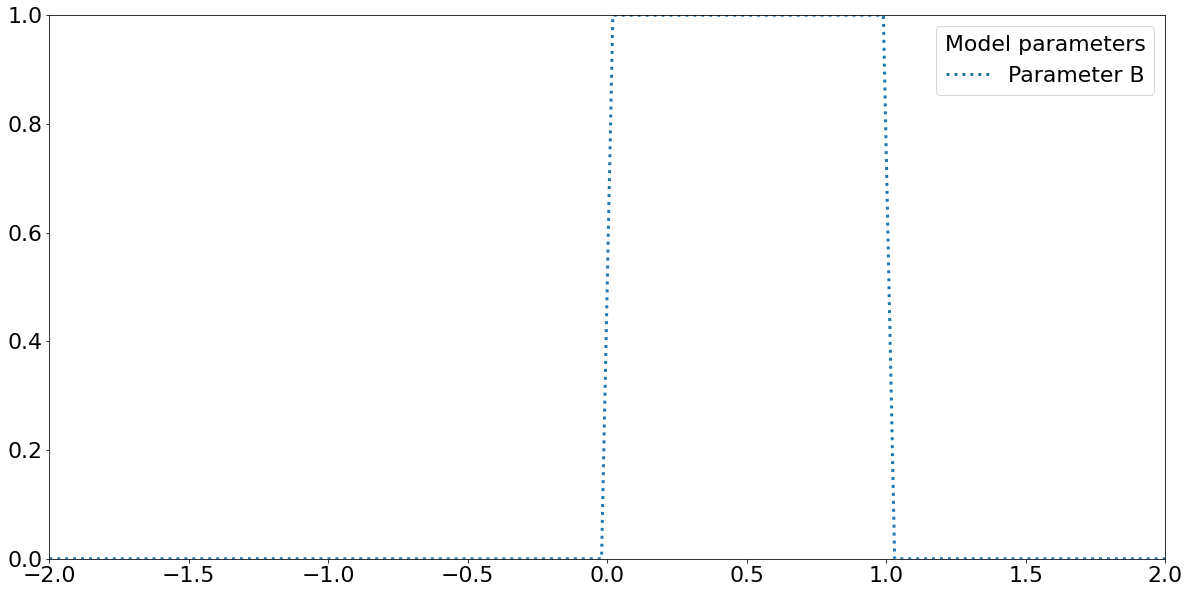

In [55]:
"""
Visualising this to see if plots are okay. 
"""
x = np.linspace(-2 ,2, 100)
lines = plt.plot(x, pyabc.Distribution(param=param_b_rv).pdf({"param": x}), ':',
                 label = "Parameter B", lw = 3)
plt.autoscale(tight=True)
plt.legend(title=r"Model parameters");
plt.show()

In [56]:
"""
Lower bound is 0, for the returned value
"""
priors = pyabc.Distribution(
    param_b=pyabc.LowerBoundDecorator(param_b_rv, 0.0))

### Running ABC and Visualisations

In [57]:
"""
Running the package
"""
abc = pyabc.ABCSMC(
    models=my_model,  
    parameter_priors=priors, 
    distance_function=distance,
    sampler=pyabc.sampler.SingleCoreSampler()
    #sampler=pyabc.sampler.MulticoreEvalParallelSampler()
    )

In [58]:
db_path = ("sqlite:///" + "abc_database.db")

In [59]:
run_id = abc.new(db_path, {'observation': obs})
print(f"Running new ABC with id {run_id}.... ", flush=True)

INFO:History:Start <ABCSMC id=121, start_time=2021-06-28 16:00:19.123211>


Running new ABC with id <pyabc.storage.history.History object at 0x7ffa2b721e50>.... 


In [60]:
abc_history = abc.run(max_nr_populations=10, minimum_epsilon=0.2)

INFO:ABC:Calibration sample t=-1.
INFO:Epsilon:initial epsilon is 1.0
INFO:ABC:t: 0, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.3343e+01.
INFO:ABC:t: 2, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.8929e+01.
INFO:ABC:t: 3, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6301e+01.
INFO:ABC:t: 4, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.3872e+01.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6639e+01.
INFO:ABC:t: 6, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6633e+01.
INFO:ABC:t: 7, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.1829e+01.
INFO:ABC:t: 8, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6279e+01.
INFO:ABC:t: 9, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6956e+01.
INFO:pyabc.util:Stop

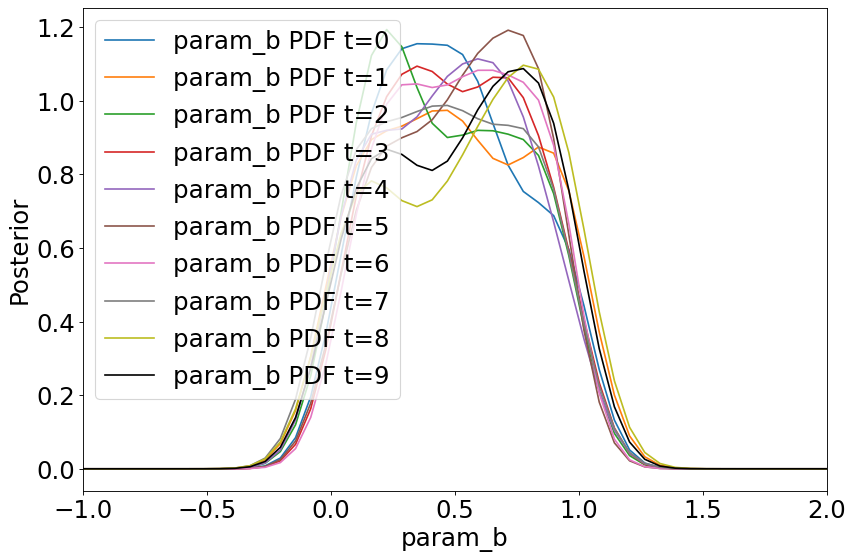

In [61]:
fig, ax = plt.subplots(figsize=(12,8), dpi=80)
for i, param in enumerate(priors.keys()):
    for t in range(abc_history.max_t+1):
        df, w = abc_history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, xmin = -1, xmax= 2,
                                        label=f"{param} PDF t={t}",
                                        # Make earlier populations transparent
                                        color="black" if t == abc_history.max_t else None  # Make the last one black
                                        )
ax.legend()
fig.savefig('posterior.png')

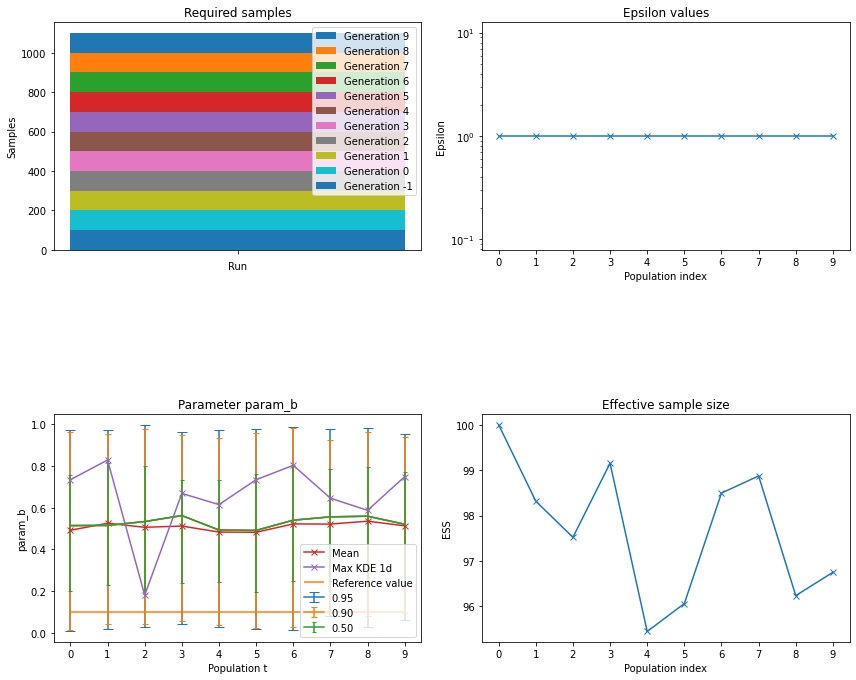

In [35]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(abc_history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(abc_history, ax=arr_ax[0][1])
pyabc.visualization.plot_effective_sample_sizes(abc_history, ax=arr_ax[1][1])
pyabc.visualization.plot_credible_intervals(
    abc_history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    show_mean=True, show_kde_max_1d=True,
    refval={'param_b': 0.1}, arr_ax=arr_ax[1][0])

plt.gcf().set_size_inches((12, 10))
plt.gcf().tight_layout()
plt.savefig('posterior_output.png')

In [36]:
for i, param in enumerate(priors.keys()):
    for t in range(abc_history.max_t+1):
        df, w = abc_history.get_distribution(m=0, t=t)
        X, Y = pyabc.visualization.kde.kde_1d(df, w, x = param)
        mode = X[np.where(Y == max(Y))]
        print('t:%d, mode:%f' % (t, mode))

t:0, mode:0.729868
t:1, mode:0.819776
t:2, mode:0.172766
t:3, mode:0.674858
t:4, mode:0.621408
t:5, mode:0.742987
t:6, mode:0.812012
t:7, mode:0.636317
t:8, mode:0.590137
t:9, mode:0.743861
